In [1]:
import numpy as np
import pickle
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import shap
import pandas

In [2]:
glove_file = datapath('glove.6B.300d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_model = gensim.models.KeyedVectors.load_word2vec_format(tmp_file)


In [3]:
def nidxv(v, model):
    res = model.similar_by_vector(v)
    ridxs = np.zeros(model.vectors.shape[0], dtype='float64')
    i = 0
    for r in res:
        ridxs[glove_model.vocab[r[0]].index] = r[1]
    return softmax(ridxs)

In [4]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))


In [5]:
def nidx(word, model):
    res = model.most_similar(positive=[word])
    ridxs = np.empty(len(res), dtype='float64')
    i = 0
    for r in res:
        ridxs[i]= glove_model.vocab[r[0]].index
        i = i+1
    return ridxs

In [6]:
def sim_vec(vecs):
    res = np.zeros((vecs.shape[0], glove_model.vectors.shape[0]))
    i = 0
    for v in vecs:
        res[i] = nidxv(v, glove_model)
        i = i+1
    return res
    

In [7]:
xw = glove_model['man']
print(xw)
lr = nidxv(xw,glove_model)
print(lr)
print(lr.sum(0))

[-0.29784   -0.13255   -0.14505   -0.22752   -0.027429   0.11005
 -0.039245  -0.0089607 -0.18866   -1.1213     0.34793   -0.30056
 -0.50103   -0.031383  -0.032185   0.018318  -0.090429  -0.14427
 -0.14306   -0.057477  -0.020931   0.56276   -0.018557   0.15168
 -0.25586   -0.081564   0.2803    -0.10585   -0.16777    0.21814
 -0.11845    0.56475   -0.12645   -0.062461  -0.68043    0.10507
  0.24793   -0.20249   -0.30726    0.42815    0.38378   -0.19371
 -0.075951  -0.058287  -0.067195   0.2192     0.56116   -0.28156
 -0.13705    0.45754   -0.14671   -0.18562   -0.074146   0.60737
  0.07952    0.41023    0.18377   -0.08532    0.43795   -0.34727
  0.2077     0.50454    0.40244    0.1095    -0.48078   -0.22372
 -0.54619   -0.20782    0.13751   -0.16206   -0.24835    0.17124
  0.037355   0.14547   -0.056205   0.2644    -0.38029    0.0029947
  0.051608   0.21807   -0.071087   0.31543    0.24593    0.34444
 -0.36354   -0.12137   -0.013511   0.049564   0.031386   0.10316
 -0.44301    0.11663   

In [8]:
t = np.zeros((2, 300))
t[0] = glove_model['man']
t[1] = glove_model['woman']
sim_vec(t).sum(1)

array([1., 1.])

In [9]:
ts = 40001
j = 0
test = np.empty(ts,dtype=object)
for w in list(glove_model.vocab.keys())[:ts]:
    test[j] = glove_model[w]
    j = j + 1

In [10]:
features = np.stack(test[:])
df_features = pandas.DataFrame(features[0:,0:], 
                      index=['Row '+str(i) for i in range(features.shape[0])], 
                      columns=['f'+str(i) for i in range(features.shape[1])]
                     )
df_features.head()



,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299
Row 0,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.6413,...,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
Row 1,-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.3854,...,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
Row 2,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.6785,...,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
Row 3,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.5721,...,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
Row 4,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.8477,...,-0.012806,-0.597070,0.317340,-0.252670,0.543840,0.063007,-0.049795,-0.160430,0.046744,-0.070621


In [11]:
bckgr = shap.sample(df_features, 100)
explainer = shap.SamplingExplainer(sim_vec, bckgr)

In [12]:
x_test = df_features[:100]

In [13]:
shap_values = explainer.shap_values(x_test, n_samples=5)


KeyboardInterrupt: 

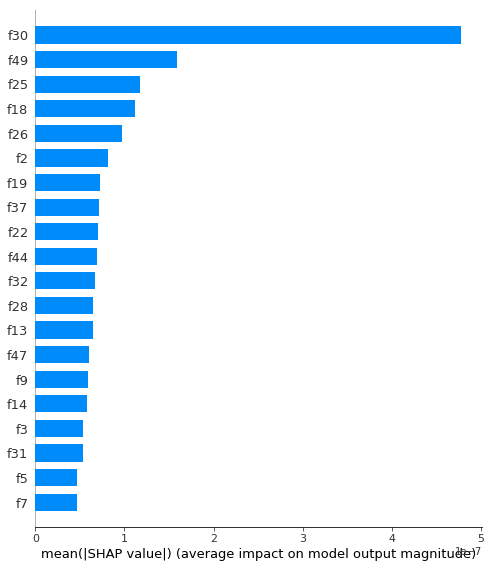

In [22]:
shap.summary_plot(shap_values[0], bckgr, plot_type='bar')

In [ ]:
mean_abs_feature_importance = np.zeros(x_test.shape[1])
for c in shap_values:
    mean_abs_feature_importance = mean_abs_feature_importance + (np.sum(np.abs(c), axis=0) / x_test.shape[0])

In [ ]:
ind = np.argpartition(mean_abs_feature_importance, -150)[-150:]
retain = np.sort(ind)
retain

In [ ]:
newweights = np.copy(glove_model.vectors)
newweights.shape

In [ ]:
newweights = newweights[:, retain]
newweights.shape

In [ ]:
glove_model.vectors = newweights
print(glove_model.most_similar(positive=['man']))
glove_model.save_word2vec_format('shap-reduced-samplesimilarity-300-150-vectors.txt', binary=False)